## Packages
Install necessary packages: numpy, control, and multiprocessing.

In [1]:
!pip install -r requirements.txt -U

  Using cached ipympl-0.9.4-py3-none-any.whl.metadata (8.7 kB)
  Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl.metadata (755 bytes)
  Using cached ipython-8.29.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached traitlets-5.14.3-py3-none-any.whl.metadata (10 kB)
  Using cached decorator-5.1.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached jedi-0.19.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached matplotlib_inline-0.1.7-py3-none-any.whl.metadata (3.9 kB)
  Using cached prompt_toolkit-3.0.48-py3-none-any.whl.metadata (6.4 kB)
  Using cached pygments-2.18.0-py3-none-any.whl.metadata (2.5 kB)
  Using cached stack_data-0.6.3-py3-none-any.whl.metadata (18 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached pexpect-4.9.0-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached comm-0.2.2-py3-none-any.whl.metadata (3.7 kB)
  Using cached widgetsnbextension-4.0.13-py3-n

In [2]:
# Import necessary packages
import re

import numpy as np
import control as ct

from typing import Callable, Tuple

import matplotlib.pyplot as plt

## Plot
Given a transfer function **H**, frequency range **\[start, end\]**, and propagation delay **delay**, we numerically approximate the transfer function given a square wave amplifier, which theoretically produces an infinite number of harmonics. If there is no propagation delay or it is already approximated in the transfer function, **delay** defaults to the floating point ε to approximate the limit form mentioned in Putzey's paper.

In [3]:
from modules.calc_resp import precompute_consts, calc_resp

def calc(
    H: ct.TransferFunction, 
    start: float, 
    end: float, 
    delay=np.finfo(np.longdouble).eps,
    num_freqs=1_000,
    num_duty_cycles=100,
    num_harmonics=100.
) -> Tuple[np.ndarray]:
    consts = list(precompute_consts(num_freqs, num_duty_cycles, num_harmonics, (start, end)))
    
    mags, phs, osc_fs, dcins, dcgains = calc_resp(np.array(H.num[0])[:,::-1], np.array(H.den[0])[:,::-1], np.array([delay]), *consts)
    
    consts[0] = np.imag(consts[0]) / (2 * np.pi)
    osc_fs /= 2 * np.pi
    phs -= np.pi

    return (mags[0], phs[0], osc_fs[0], dcins[0], dcgains[0]), consts[:3]

In [4]:
def plot(
    H: ct.TransferFunction, 
    start: float, 
    end: float, 
    delay=np.finfo(np.longdouble).eps
) -> None:
    """ Takes a SISO transfer function `H` and plots phase response and loop gain vs.
    frequency, oscillation frequency vs. duty cycle, DC transfer curve, and loop gain 
    vs. duty cycle. """

    (mags, phs, osc_fs, dcins, dcgains), (omega, hs, ns) = calc(H, start, end, delay)
    
    # Plotting
    fig, ((ax_ph, ax_dcgain), (ax_osc, ax_dcin)) = plt.subplots(2,2)

    # Set figure labels
    ax_osc.set_ylabel('Osc. Freq. (Hz)')
    ax_osc.set_xlabel('Duty Cycle')

    ax_ph.set_xlabel('Frequency (Hz)')
    ax_ph.set_ylabel('Phase (°)')
    ax_mag = ax_ph.twinx()
    ax_mag.set_ylabel('Magnitude (dB)')

    # Plot phase
    cs = ['b','g','c','y']
    for i, p in enumerate(phs[-1:0:-(hs.size // 5),:]):
        ax_ph.plot(omega, np.degrees(np.unwrap(p)), f'{cs[i % len(cs)]}--')

    ax_ph.plot([start, end], [-180, -180], 'k:')
    ax_ph.set_xscale('log')

    max_ph = max(np.ceil(np.degrees(np.max(phs))), 0) + 10
    ax_ph.set_yticks([0, -180, -360])
    ax_ph.set_ylim(-360-max_ph, max_ph)

    # Plot oscillation frequencies
    ax_osc.plot(
        np.concatenate((hs, 1-hs[-1::-1])),
        np.concatenate((osc_fs, osc_fs[-1::-1]))
    )

    # Plot dcin
    ax_dcin.plot(
        np.concatenate((-dcins, dcins[-1::-1])),
        np.concatenate((2 * hs - 1, - 2 * hs[-1::-1] + 1))
    )

    # Plot dcgain
    ax_dcgain.plot(
        np.concatenate((2 * hs - 1, - 2 * hs[-1::-1] + 1)),
        np.concatenate((dcgains, dcgains[-1::-1]))
    )

    # Plot magnitudes
    mag_scaled = 20 * np.log10(dcgains[-1] * mags[-1])
    ax_mag.plot(omega, mag_scaled, 'r-')
    
    max_mag = round(max(
        *map(
            np.abs, 
            (np.min(mag_scaled), np.max(mag_scaled))
        ), 
        0
    )) + 3
    ax_mag.set_ylim(-max_mag, max_mag)

    fig.tight_layout()



## Transfer Functions

As per Bruno Putzey's 2011 paper titled ["Global Modulated Self-Oscillating Amplifier with Improved Linearity"](https://www.hypex.nl/media/3f/62/4a/1682342035/Globally%20modulated%20self-oscillating%20amplifier.pdf), we treat our Class-D amplifier as a square wave oscillator wrapped with a linear function. For simplicity's sake, we further split said linear function into three serial sections–the **propagation delay**, **low pass filter**, and **feedback network**. The **propagation delay** is calculated during numerical evaluation in order to avoid using a Padé approximation. Please define functions constructing transfer functions based on component values for the **low pass filter** and **feedback network** below.

## Workspace

In [20]:
from modules.sapwin import Sapwin

problem = Sapwin(filename='../sym_analysis/SapWin/class_d_ucd.out', n_fs=1_000, n_ns=200)

In [21]:
from pymoo.algorithms.soo.nonconvex.de import DE

algorithm = DE(
    pop_size=500,
    CR=0.9,
    F=1.,
    dither='vector',
    jitter=False
)

In [22]:
from pymoo.optimize import minimize

res = minimize(
    problem,
    algorithm,
    termination=('n_gen', 100),
    seed=1,
    save_history=True,
    verbose=True
)

/Users/aaron/projects/class-d-amp/loop_analysis/python/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      500 |           INF |  0.0475561502
     2 |     1000 |           INF |  0.0034344139
     3 |     1500 |  1.7714200802 |  0.0034344139
     4 |     2000 |  0.3077679951 |  0.0034344139
     5 |     2500 |  0.0521385376 |  0.0033989367
     6 |     3000 |  0.0176549169 |  0.0033435881
     7 |     3500 |  0.0111078126 |  0.0033403966
     8 |     4000 |  0.0073792333 |  0.0032144128
     9 |     4500 |  0.0060044500 |  0.0025155474
    10 |     5000 |  0.0051128007 |  0.0024842064
    11 |     5500 |  0.0044865850 |  0.0024842064
    12 |     6000 |  0.0040987026 |  0.0024842064
    13 |     6500 |  0.0038824184 |  0.0024842064
    14 |     7000 |  0.0036872001 |  0.0024471735
    15 |     7500 |  0.0034832722 |  0.0023772030
    16 |     8000 |  0.0033199463 |  0.0023772030
    17 |     8500 |  0.0032045913 |  0.0023736873
    18 |     9000 |  0.0030996417 |  0.0023615677
    19 |     9500 |  0.0029712391 |  0.0023615677


In [23]:
X = res.X
F = res.F

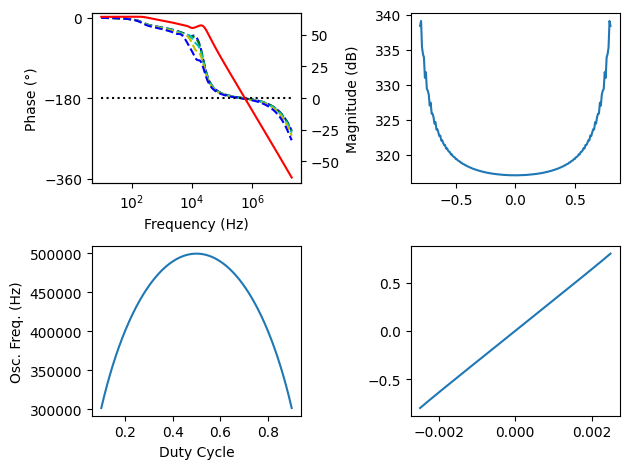

In [24]:
vals = X[:-1][None,:]
delay = X[-1]

num = problem._calc_num(vals)[0,::-1]
den = problem._calc_den(vals)[0,::-1]

plot(ct.tf(num, den), 10, 2e7, delay)